/Users/nandanthor/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/nandanthor/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/8
6s - loss: 0.1082
Epoch 2/8
4s - loss: 0.0345
Epoch 3/8
4s - loss: 0.0271
Epoch 4/8
5s - loss: 0.0238
Epoch 5/8
5s - loss: 0.0217
Epoch 6/8
4s - loss: 0.0176
Epoch 7/8
4s - loss: 0.0155
Epoch 8/8
4s - loss: 0.0158
train score: 113262.42 RMSE
test score: 119973.30 RMSE


/Users/nandanthor/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


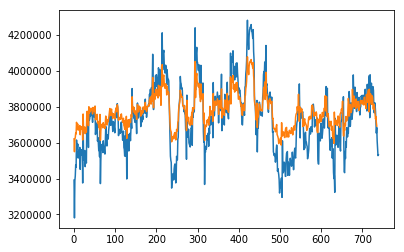

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


#Helper function: Convert time series to dataset

def create_ds(dataset, offset = 1):
    X , y = [], []
    for i in range(len(dataset)-offset-1):
        a = dataset[i:(i+offset)]
        X.append(a)
        y.append(dataset[i + offset])
    return np.array(X), np.array(y)

########################################################

#Input data
data = pd.read_csv('unique_sales.csv')

da = data['SUM']
#da.dropna(inplace = True)

rm = da.rolling(center=False, window = 21).mean()
da = rm
da.dropna(inplace = True)
#load data
dataset = da.values
dataset = dataset.astype('float32')

#normalize - only on training set or on all data?
sclr = MinMaxScaler(feature_range = (0,1))
dataset = sclr.fit_transform(dataset)

#Split data into 80% training, 20% test
train_size = int(len(dataset) * 0.67)
test_size = int(len(dataset) * 0.67)

#Define test and train data
train = dataset[0:train_size]
test = dataset[train_size:len(dataset)]


# We want to predict t using t-1, use helper function
offset = 1
train_X, train_y = create_ds(train, offset)
test_X, test_y = create_ds(test, offset)

#Reshape data to make RNN happy
train_X = np.reshape(train_X, (train_X.shape[0],1,train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0],1,test_X.shape[1]))


# Finally, create the neural network
model = Sequential()
model.add(LSTM(5, input_shape=(1, offset)))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(train_X, train_y, epochs = 8, batch_size = 1, verbose = 2)


#Build evaluation metrics
predict_train = model.predict(train_X)
predict_test = model.predict(test_X)

predict_train = sclr.inverse_transform(predict_train)
trainY = sclr.inverse_transform([train_y])
predict_test = sclr.inverse_transform(predict_test)
testY = sclr.inverse_transform([test_y])

#RMSE
train_score = math.sqrt(mean_squared_error(trainY[0], predict_train[:,0]))
print('train score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(testY[0], predict_test[:,0]))
print('test score: %.2f RMSE' % (test_score))

trainpredplot = np.empty_like(dataset)
trainpredplot[:] = np.nan
#trainpredplot[offset:(len(predict_train)+offset)] = predict_train
#             
#testpredplot = np.empty_like(dataset)
#testpredplot[:] = np.nan
#testpredplot[offset:len(predict_test)+offset, :] = predict_test
predic_t = np.append(predict_train, predict_test)
plt.plot(sclr.inverse_transform(dataset))
#plt.plot(predict_train)
#plt.plot(predict_test)
plt.plot(predic_t)
plt.show()

